EE559: A simple implementation of MLP for a Binary Classification Problem

Instructors: Prof. Keith Chugg (chugg@usc.edu) & Prof. B. Keith Jenkins (jenkins@sipi.usc.edu)

Notebook: Torch verision - Written by TA Chengwei Wei (chengwei@usc.edu)
Sklearn version - Written by TA Thanos Rompokos (rompokos@usc.edu)

Adapted from: 
https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/
https://www.kaggle.com/code/pinocookie/pytorch-simple-mlp/notebook

make sure torch is installed (https://pytorch.org/)

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn import preprocessing
import numpy as np
from tqdm import tqdm

read dataset 3 from HW1 which is not linear seperable

And we will see the performance of MLP with non-linear activation on this dataset

In [2]:
df_train3 = pd.read_csv('./HW1_datasets/dataset3_train.csv', header=None, names=["x", "y", "class"])
X_train3 = df_train3[['x', 'y']].to_numpy()
Y_train3 = df_train3[['class']].to_numpy().ravel()

df_test3 = pd.read_csv('./HW1_datasets/dataset3_test.csv', header=None, names=["x", "y", "class"])
X_test3 = df_test3[['x', 'y']].to_numpy()
Y_test3 = df_test3[['class']].to_numpy().ravel()

## preprocessing
# Convert Class String labels into Integers
lab_enc = preprocessing.LabelEncoder()
Y_train3 = lab_enc.fit_transform(Y_train3)
Y_test3 = lab_enc.transform(Y_test3)


### Sklearn

In [3]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(10,), max_iter=200,activation = 'relu',solver='adam', batch_size=2)

In [4]:
#Fitting the training data to the network
clf.fit(X_train3, Y_train3.ravel())

/Users/chengwei/opt/anaconda3/envs/ee559/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=2, hidden_layer_sizes=(10,))

In [5]:
print('No of layers:',clf.n_layers_)
print('Hidden layer activation function:',clf.activation)
print('Output layer activation function:',clf.out_activation_)

No of layers: 3
Hidden layer activation function: relu
Output layer activation function: logistic


In [6]:
#Predicting y for X_train & test
y_train_pred = clf.predict(X_train3)
y_test_pred = clf.predict(X_test3)

In [7]:
from sklearn.metrics import accuracy_score
print('Train accuracy:',accuracy_score(y_train_pred,Y_train3))
print('Test accuracy:',accuracy_score(y_test_pred,Y_test3))

Train accuracy: 0.94
Test accuracy: 0.92


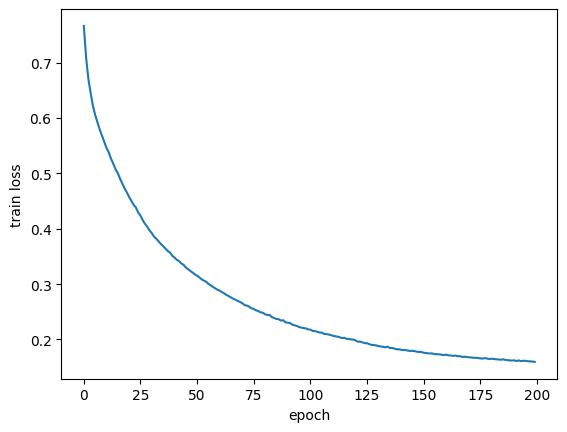

In [8]:
import matplotlib.pyplot as plt
plt.plot(clf.loss_curve_)
plt.ylabel('train loss')
plt.xlabel('epoch')
plt.show()

#### Add an extra hidden layer

In [9]:
clf_extra = MLPClassifier(hidden_layer_sizes=(5,10), max_iter=200,activation = 'relu',solver='adam', batch_size=2)
print('No of layers:',clf.n_layers_)
print('Hidden layer activation function:',clf.activation)
print('Output layer activation function:',clf.out_activation_)
clf_extra.fit(X_train3, Y_train3.ravel())

No of layers: 3
Hidden layer activation function: relu
Output layer activation function: logistic


/Users/chengwei/opt/anaconda3/envs/ee559/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=2, hidden_layer_sizes=(5, 10))

In [10]:
y_train_pred = clf_extra.predict(X_train3)
y_test_pred = clf_extra.predict(X_test3)
print('Train accuracy:',accuracy_score(y_train_pred,Y_train3))
print('Test accuracy:',accuracy_score(y_test_pred,Y_test3))

Train accuracy: 0.96
Test accuracy: 0.93


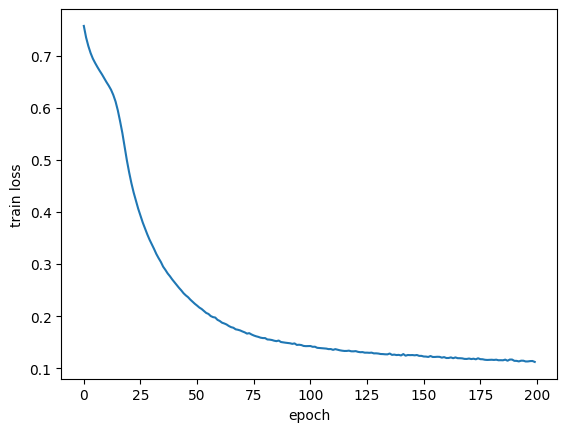

In [11]:
import matplotlib.pyplot as plt
plt.plot(clf_extra.loss_curve_)
plt.ylabel('train loss')
plt.xlabel('epoch')
plt.show()

### Torch

no gpu on this device, let's use cpu instead

In [12]:
torch.cuda.is_available()

False

In [13]:

# # Normalize the input features of the dataset
# normalizer = preprocessing.StandardScaler()
# X_train = normalizer.fit_transform(X_train)
# X_test = normalizer.fit_transform(X_test)

# convert to torch tensor
X_train3 = torch.tensor(X_train3, dtype=torch.float32)
Y_train3 = torch.tensor(Y_train3, dtype=torch.float32).reshape(-1, 1)
X_test3 = torch.tensor(X_test3, dtype=torch.float32)
Y_test3 = torch.tensor(Y_test3, dtype=torch.float32).reshape(-1, 1)

In [14]:
torch.unique(Y_test3)

tensor([0., 1.])

build the model

In [15]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLP, self).__init__()
        # the layers you want to put in the models
        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # how the input move forward in the model
        x = self.relu(self.hidden1(x)) # first go through hidden1 layer, and then relu
        x = self.sigmoid(self.output(x)) #  go through output layer, and then sigmoid
        return x

In [16]:
model = MLP(2, 10) # build a MLP where the input feature has 2 dim, and the hidden dim is 10
print(model)

MLP(
  (hidden1): Linear(in_features=2, out_features=10, bias=True)
  (relu): ReLU()
  (hidden2): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Optimizer and Loss function

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # lr = learning rate
loss_fn = nn.BCELoss() # binary cross entropy for a binary classifcaiton

A simple training process, no early stop, adpative lr ...

In [18]:
n_epochs = 200   # number of epochs to run
batch_size = 2  # size of each batch
batch_start = torch.arange(0, len(X_train3), batch_size)

mean_train_losses = []
for epoch in range(n_epochs):
    model.train() # tells your model that you are training the model
    
    train_losses = []
    with tqdm(batch_start, unit="batch") as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train3[start:start+batch_size]
            y_batch = Y_train3[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            train_losses.append(loss.item())
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            acc = (y_pred.round() == y_batch).float().mean()
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    mean_train_losses.append(np.mean(train_losses))

Epoch 199: 100%|██████████| 50/50 [00:00<00:00, 569.73batch/s, acc=1, loss=0.0541]


Training loss plot

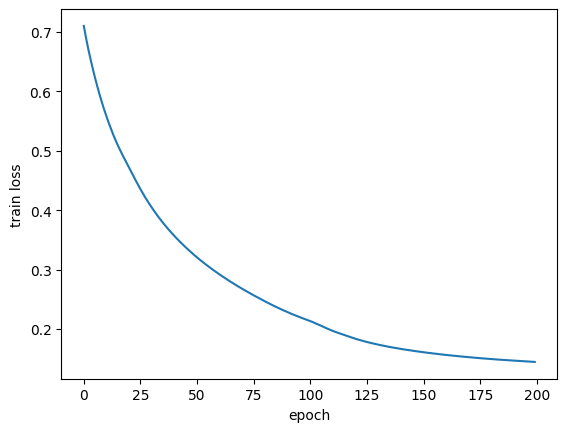

In [19]:
import matplotlib.pyplot as plt
plt.plot(mean_train_losses)
plt.ylabel('train loss')
plt.xlabel('epoch')
plt.show()

Evalution on test set

It works well on this non linear seperable dataset

In [20]:
# evaluate accuracy at end of each epoch
model.eval() # tells your model that you are evaluating the model, no parameters will be updated
Y_pred3 = model(X_test3)
acc = (Y_pred3.round() == Y_test3).float().mean()
acc = float(acc)
print('Test Acc:', acc)

Test Acc: 0.9300000071525574


Save and load the entire Model

In [21]:
# Save
PATH = 'final_model.pt'
torch.save(model, PATH)

In [22]:
# Load
PATH = 'final_model.pt'
# Model class must be defined somewhere
model = torch.load(PATH)
model.eval()

MLP(
  (hidden1): Linear(in_features=2, out_features=10, bias=True)
  (relu): ReLU()
  (hidden2): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)